CREATE TABLE ML_WAVEFORMS
(
  WAVEFORMID        NUMBER NOT NULL PRIMARY KEY,
  ARID              NUMBER NOT NULL,
  TIMEA             FLOAT,  -- time of automatic detection, N phase or manual detection can have NULL
  TIMELEB           FLOAT,  -- onset time in LEB, N phase can have NULL  
  IPHASE            VARCHAR2(8), -- iwt label
  IPHASECL          VARCHAR2(8), -- iwt class
  IPHASECLNUM       NUMBER, -- iwt class numerical code (for confidence matrix)
  PHASE             VARCHAR2(8),  -- phase label as in LEB assoc
  PHASECL           VARCHAR2(8),  -- phase class
  PHASECLNUM        NUMBER,  -- phase class numerical code (for confidence matrix)
  SOURCE            VARCHAR2(1), -- A - automatic phase family type remained after association, H - automatic phase family changed by analyst, M - manually added by analysts (no automatice detection) 
  NET               VARCHAR2(8) NOT NULL,
  STA               VARCHAR2(8) NOT NULL,
  CHAN              VARCHAR2(8) NOT NULL,
  SAMPRATE          FLOAT,
  STARTTIME         FLOAT,
  ENDTIME           FLOAT,
  NSAMP             NUMBER,
  CALIB             FLOAT,
  SAMPLES           BLOB --calibrated to 4byte float samples in binary
) ENABLE PRIMARY KEY USING INDEX;

In [171]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import cx_Oracle as db
import numpy
import pandas
from datetime import datetime as dt

import src.read_wfdisc

In [62]:
with open('/home/hofman/.dbp.txt', 'r') as f:
    dbpwd = f.read().strip()
    connection_qandef = db.connect('hofman[retraining]/%s@%s' % (dbpwd, 'dba1091.qandef'))
    connection_udb = db.connect('hofman/%s@%s' % (dbpwd, 'udb.ctbto.org')) #, encoding = "UTF-8", nencoding = "UTF-8")
    connection_extadb = db.connect('hofman/%s@%s' % (dbpwd, 'extadb.ctbto.org'))

In [63]:
cursor_qandef = connection_qandef.cursor()
cursor_udb = connection_udb.cursor()
cursor_extadb = connection_extadb.cursor()

WAVEFORMID        NUMBER NOT NULL PRIMARY KEY,
  ARID              NUMBER NOT NULL,
  TIMEA             FLOAT,  -- time of automatic detection, N phase or manual detection can have NULL
  TIMELEB           FLOAT,  -- onset time in LEB, N phase can have NULL  
  IPHASE            VARCHAR2(8), -- iwt label
  IPHASECL          VARCHAR2(8), -- iwt class
  IPHASECLNUM       NUMBER, -- iwt class numerical code (for confidence matrix)
  PHASE             VARCHAR2(8),  -- phase label as in LEB assoc
  PHASECL           VARCHAR2(8),  -- phase class
  PHASECLNUM        NUMBER,  -- phase class numerical code (for confidence matrix)
  SOURCE            VARCHAR2(1), -- A - automatic phase family type remained after association, H - automatic phase family changed by analyst, M - manually added by analysts (no automatice detection) 
  STA               VARCHAR2(8) NOT NULL,
  CHANNELS = 
  SAMPRATE          FLOAT,
  STARTTIME         FLOAT,
  ENDTIME           FLOAT,
  NSAMP             NUMBER,
  CALIBS            BLOB,  -- 4byte calibs in a vector, number of calibs = number of channels
  SAMPLES           BLOB --calibrated to 4byte float samples in binary

## Extract associated waveforms from the LEB

In [104]:
key_iphase_regS = ('Sn', 'Lg', 'Rg', 'Sx')
key_iphase_regP = ('Pn', 'Pg', 'Px')
key_iphase_tele = ('P', 'PKP', 'PKPbc', 'PcP', 'PKPab', 'pP', 'PP', 'PKKPbc', 'ScP', 'SKPbc', 'PKhKP', 'PKiKP', 'PKP2', 'Pdiff', 'SKP', 'pPKP', 'PKKPab', 'pPKPbc', 'PKKP', 'SKKPbc', 'PKP2bc', 'P3KPbc', 'sP', 'SKPab', 'P4KPbc', 'PKP2ab', 'pPKPab', 'P3KP', 'SKKP', 'SKiKP', 'SKKPab', 'SKKS', 'P4KP', 'SP', 'S', 'ScS', 'SS', 'Sdiff', 'pPcP', 'sPKP', 'tx')

key_phase_regS  = ('Sn', 'Lg', 'Rg')
key_phase_regP  = ('Pn', 'Pg')
key_phase_tele  = ('P', 'PKP', 'PKPbc', 'PcP', 'PKPab', 'pP', 'PP', 'PKKPbc', 'ScP', 'SKPbc', 'PKhKP', 'PKiKP', 'PKP2', 'Pdiff', 'SKP', 'pPKP', 'PKKPab', 'pPKPbc', 'PKKP', 'SKKPbc', 'PKP2bc', 'P3KPbc', 'sP', 'SKPab', 'P4KPbc', 'PKP2ab', 'pPKPab', 'P3KP', 'SKKP', 'SKiKP', 'SKKPab', 'SKKS', 'P4KP', 'SP', 'S', 'ScS', 'SS', 'Sdiff', 'pPcP', 'sPKP')

DIPHASECL = {key_iphase_regS: 'S',
             key_iphase_regP: 'P',
             key_iphase_tele: 'T'}

DIPHASECLNUM = {'S': 1,
                'P': 2,
                'T': 3}

DPHASECL = {key_phase_regS: 'S',
            key_phase_regP: 'P',
            key_phase_tele: 'T'}

DIPHASECLNUM = DIPHASECLNUM

def get_phase_cl(phase, DPHASE):
    for key in DPHASE.keys():
        if phase in key:
            return DPHASE[key]


In [167]:
def ts(*date):
    """
    wotks in py3
    :param datetime:
    :return: timestamp from datetime
    """
    #print(dt(*date), dt(*date).timestamp())
    return dt(*date).timestamp()


def get_channels_of_sta(sta):
    query = """select distinct(chan) from static.sitechan where sta=:1 and offdate=-1"""
    res = cursor_extadb.execute(query, (sta,))
    return tuple(sorted((x[0] for x in res)))


def get_samprate_3C(sta, time):
    channels = get_channels_of_sta(sta)
    query = """select distinct(samprate) from idcx.wfdisc where sta='%s' and chan in %s and time<= %10.9f and endtime >= %10.9f""" % (sta, str(channels), time, time)
    res = cursor_extadb.execute(query)
    samprates = list((x[0] for x in res))
    if min(samprates) == max(samprates):
        return samprates[0]
    else:
        print('Different samprates in channel!!!', samprates)
        return None
    
    
def get_calibs(sta, time):
    channels = get_channels_of_sta(sta)
    query = """select chan, calib from idcx.wfdisc where sta='%s' and chan in %s and time<= %10.9f and endtime >= %10.9f""" % (sta, str(channels), time, time)
    res = cursor_extadb.execute(query).fetchall()
    
    calibs_d = {x[0]:x[1] for x in res}
    calibs = (calibs_d[x] if x in calibs_d.keys() else None for x in channels)
    return tuple(calibs)

# tests
channels = get_channels_of_sta('JCJ')
assert channels == ('BHE', 'BHN', 'BHZ')
assert get_samprate_3C('JCJ', 1563194400) == 40.0
assert get_calibs('JCJ', 1563494400) == (0.038118, 0.038131, 0.038104)

SAMPRATE: 40.00 Hz  [40.0]
reading wfdisc:  /archive/ops/seismic/2019/028/AUXJCJ.1548633600.w
= number of samples: 2399


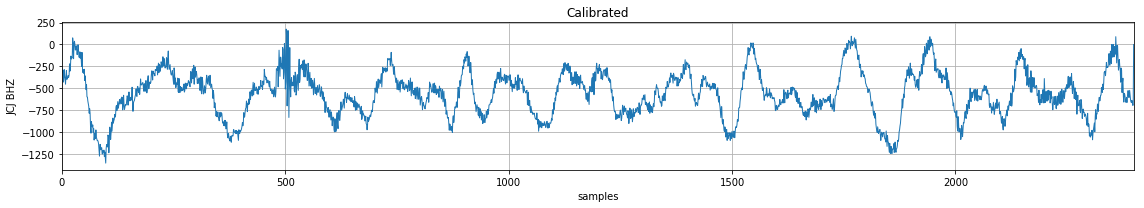

In [170]:
data, sr = src.read_wfdisc.get_waveform_data(sta, chan, ts(2019,1,29,0,0,0), ts(2019,1,29,0,1,0), cursor_extadb, calib=True)
src.read_wfdisc.vizualize(data, show=True, xlabel='samples', ylabel=sta+' '+chan, title='Calibrated')

In [172]:
channels = get_channels_of_sta(sta)
timeleb = 1563194400
starttime = timeleb - DELTA_DIFFERENCE
endtime =   timeleb + DELTA_DIFFERENCE

for ch in channels:
    vector = []
    data, sr = src.read_wfdisc.get_waveform_data(sta, chan, starttime, endtime, cursor_extadb, calib=True)
    vector.append(data)
    print(data.shape)


    
    
    
    

SAMPRATE: 40.00 Hz  [40.0]
Exception:
[Errno 2] No such file or directory: '/archive/ops/seismic/2019/196/AUXJCJ.1563148800.w'


AttributeError: 'NoneType' object has no attribute 'shape'

In [103]:
[row[0] for row in cursor_extadb.description]

['ARID', 'TIMEA', 'TIMELEB', 'IPHASE', 'PHASE', 'STA', 'SOURCE']

## Automtic arrivals

In [158]:
station = 'ROSC'

DELTA_DIFFERENCE = 10  # time delta difference from let time arrival

query = """
SELECT  er.arid as arid,
        er.time as timea,
        ae.time as timeleb,
        er.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'A' as source
        FROM idcx.arrival er, leb.assoc ea, leb.arrival ae
        WHERE er.sta='%s'
                AND ea.arid=er.arid
                AND ae.arid=ea.arid
""" % (station,)

###qres = cursor_extadb.execute(query)

for q in qres:
    try:
        arid = q[0]
        timea = q[1]
        timeleb = q[2]
        iphase = q[3]
        iphasecl = get_phase_cl(iphase, DIPHASECL)
        iphaseclnum = DIPHASECLNUM[iphasecl]
        phase = q[4]
        phasecl = get_phase_cl(phase, DPHASECL)
        phaseclnum = DIPHASECLNUM[phasecl]
        source = q[6]
        sta = q[5]
        channels = ','.join(get_channels_of_sta(sta))
        samprate = get_samprate_3C(sta, timeleb)
        starttime = timeleb - DELTA_DIFFERENCE
        endtime =   timeleb + DELTA_DIFFERENCE
        nsamp = 2*DELTA_DIFFERENCE*samprate
        calibs = numpy.array(get_calibs(sta, timeleb), dtype=numpy.float32).tobytes()
        samples = 

        query = """
        insert into ML_WAVEFORMS (arid, 
                                   timea, 
                                   timeleb, 
                                   iphase, 
                                   iphasecl,
                                   iphaseclnum,
                                   phase,
                                   phasecl,
                                   phaseclnum,
                                   source,
                                   sta,
                                   channels,
                                   samprate,
                                   starttime,
                                   endtime,
                                   nsamp,
                                   calibs,
                                   samples) 
        values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18)"
        """

        cursor_qandef.execute(query, (arid, 
                                      timea, 
                                      timeleb, 
                                      iphase, 
                                      iphasecl,
                                      iphaseclnum,
                                      phase,
                                      phasecl,
                                      phaseclnum,
                                      source,
                                      sta,
                                      channels,
                                      samprate,
                                      starttime,
                                      endtime,
                                      nsamp,
                                      calibs,
                                      samples))        
    except:
        print('insert failed')

cursor_qandef.execute("commit")

## Manual arrivals

In [ ]:
import time
station = 'ROSC'

DELTA_DIFFERENCE = 10  # time delta difference from let time arrival

query = """
SELECT  ae.arid as arid,
        ae.time as timea,
        ae.time as timeleb,
        ae.iphase as iphase,
        ea.phase as phase,
        ea.sta as sta,
        'M' as source
        FROM leb.assoc ea, leb.arrival ae
        WHERE ea.sta='%s'
                AND ae.arid=ea.arid
                AND ae.arid not in (select arid from idcx.arrival where sta='%s')
""" % (station, station)

###qres = cursor_extadb.execute(query)

print('extracting waveforms', time.time())

for q in qres:
    try:
        arid = q[0]
        timea = q[1]
        timeleb = q[2]
        iphase = q[3]
        iphasecl = get_phase_cl(iphase, DIPHASECL)
        iphaseclnum = DIPHASECLNUM[iphasecl]
        phase = q[4]
        phasecl = get_phase_cl(phase, DPHASECL)
        phaseclnum = DIPHASECLNUM[phasecl]
        source = q[6]
        sta = q[5]
        channels = ','.join(get_channels_of_sta(sta))
        samprate = get_samprate_3C(sta, timeleb)
        starttime = timeleb - DELTA_DIFFERENCE
        endtime =   timeleb + DELTA_DIFFERENCE
        nsamp = 2*DELTA_DIFFERENCE*samprate
        calibs = numpy.array(get_calibs(sta, timeleb), dtype=numpy.float32).tobytes()
        samples = 

        query = """
        insert into ML_WAVEFORMS (arid, 
                                   timea, 
                                   timeleb, 
                                   iphase, 
                                   iphasecl,
                                   iphaseclnum,
                                   phase,
                                   phasecl,
                                   phaseclnum,
                                   source,
                                   sta,
                                   channels,
                                   samprate,
                                   starttime,
                                   endtime,
                                   nsamp,
                                   calibs,
                                   samples) 
        values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18)"
        """

        cursor_qandef.execute(query, (arid, 
                                      timea, 
                                      timeleb, 
                                      iphase, 
                                      iphasecl,
                                      iphaseclnum,
                                      phase,
                                      phasecl,
                                      phaseclnum,
                                      source,
                                      sta,
                                      channels,
                                      samprate,
                                      starttime,
                                      endtime,
                                      nsamp,
                                      calibs,
                                      samples))        
    except:
        print('insert failed')

cursor_qandef.execute("commit")

In [159]:
len(result)

22104

In [ ]:
#temporal condition
AND er.lddate >= to_date('''||to_char(start_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND er.lddate  < to_date('''||to_char(end_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND ea.lddate >= to_date('''||to_char(start_date,'yy-mm-dd')||''', ''yy-mm-dd'') 
AND ea.lddate  < to_date('''||to_char(end_date,'yy-mm-dd')||''', ''yy-mm-dd'') 

## Extract noise phases far from any arrivals

In [76]:
cursor_qandef.execute("insert into ML_WAVEFORMS (arid, timea, timeleb, iphase, iphasecl,iphaseclnum,phase,phasecl,phaseclnum,source,net,sta,chan,samprate,starttime,endtime,nsamp,calib,samples) values (:1, :2, :3, :4, :5, :6, :7, :8, :9, :10, :11, :12, :13, :14, :15, :16, :17, :18, :19)", 
                   (1, 1,1,'A','c',79,'sdas','cs',31,'M','urz','urz','bhz',40,232,454654,400,12,xb))      
cursor_qandef.execute("commit")

In [65]:
cursor_qandef.execute("select * from ML_WAVEFORMS")

<cx_Oracle.Cursor on <cx_Oracle.Connection to hofman[retraining]@dba1091.qandef>>

In [9]:
my_str = "hello world"
my_str_as_bytes = str.encode(my_str)

In [73]:
import numpy
x = numpy.array([[0, 1.], [2, 3]], dtype=numpy.float32)
xb = x.tobytes()

numpy.array(get_calibs('JCJ', 1563494400), dtype=numpy.float32).tobytes()

In [74]:
type(x)

numpy.ndarray

In [99]:
a = cursor_udb.execute("select * from ML_WAVEFORMS where waveformid = 1001")
for res in a:
    print(numpy.frombuffer(res[-1].read(), dtype=numpy.int64).reshape((2,2)))

[[0 1]
 [2 3]]


In [32]:
a

<cx_Oracle.Cursor on <cx_Oracle.Connection to hofman@udb.ctbto.org>>

In [33]:
for res in a:
    print(numpy.frombuffer(res[-1].read())) #, dtype=numpy.float64))

[0.0e+000 4.9e-324 9.9e-324 1.5e-323]


In [101]:
[row[0] for row in cursor_qandef.description]

['WAVEFORMID',
 'ARID',
 'TIMEA',
 'TIMELEB',
 'IPHASE',
 'IPHASECL',
 'IPHASECLNUM',
 'PHASE',
 'PHASECL',
 'PHASECLNUM',
 'SOURCE',
 'NET',
 'STA',
 'CHAN',
 'SAMPRATE',
 'STARTTIME',
 'ENDTIME',
 'NSAMP',
 'CALIB',
 'SAMPLES']